<a href="https://colab.research.google.com/github/akomp22/rl_pong/blob/main/Pong2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import cv2
import numpy as np
import gym
import random
import time
 
import tensorflow as tf
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import (Add, Conv2D, Dense, Flatten, Input,
                                     Lambda, Subtract)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop

In [4]:
# env = gym.make('PongDeterministic-v0')
# obs = env.reset()

In [5]:
# process_frame(obs).shape

In [6]:
def process_frame(I):
  '''prepro 210x160x3 frame into 6400 (80x80) 1D float vector '''
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return np.expand_dims(I.astype(np.float),axis = 2)

In [7]:
def build_dueling_q_network(n_actions, learning_rate=0.00001, input_shape=(80, 80), history_length=4):
    """Builds a dueling DQN as a Keras model
    Arguments:
        n_actions: Number of possible action the agent can take
        learning_rate: Learning rate
        input_shape: Shape of the preprocessed frame the model sees
        history_length: Number of historical frames the agent can see
    Returns:
        A compiled Keras model
    """
    tf.random.set_seed(0)
    model_input = Input(shape=(input_shape[0], input_shape[1], history_length))
    x = Lambda(lambda layer: layer / 255)(model_input)  # normalize by 255

    x = Conv2D(32, (8, 8), strides=4, activation='relu')(x)
    x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu')(x)
    x = Conv2D(1024, (7, 7), strides=1, activation='relu')(x)
    x = Flatten()(x)
    X = Dense(1024,activation='relu')(x)
    q_vals = Dense(n_actions)(x)

    # # Split into value and advantage streams
    # val_stream, adv_stream = Lambda(lambda w: tf.split(w, 2, 3))(x)  # custom splitting layer

    # val_stream = Flatten()(val_stream)
    # val = Dense(1, kernel_initializer=VarianceScaling(scale=2.))(val_stream)

    # adv_stream = Flatten()(adv_stream)
    # adv = Dense(n_actions, kernel_initializer=VarianceScaling(scale=2.))(adv_stream)

    # # Combine streams into Q-Values
    # reduce_mean = Lambda(lambda w: tf.reduce_mean(w, axis=1, keepdims=True))  # custom layer for reduce mean

    # q_vals = Add()([val, Subtract()([adv, reduce_mean(adv)])])
    
    # Build model
    model = Model(model_input, q_vals)
    model.compile(Adam(learning_rate), loss=tf.keras.losses.Huber())

    return model

In [8]:
# model = build_dueling_q_network(4, learning_rate=0.00001, input_shape=(80, 80), history_length=4)

In [9]:
# model.summary()

In [10]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:

class Agent():
  def __init__(self,model1,model2,n_actions,gamma,batch_size):
    self.model1 = model1
    self.model2 = model2
    self.n_actions = n_actions
    self.gamma = gamma
    self.batch_size = batch_size
    np.random.seed(0)


  def get_action(self, eps, state, evaluation=False):
      if np.random.rand(1) < eps:
          return np.random.randint(0, self.n_actions)
      q_vals = agent.model1.predict_on_batch(np.expand_dims(state,axis = 0))[0]

      return q_vals.argmax()




  def learn(self,experiences):
    states, actions, rewardss, terminal_flags, new_states = map(list, zip(*experiences))

    states = np.array(states)
    actions = np.array(actions)
    rewardss = np.array(rewardss)
    terminal_flags = np.array(terminal_flags)
    new_states = np.array(new_states)

    arg_q_max = agent.model1.predict_on_batch(new_states).argmax(axis=1)

    # Target DQN estimates q-vals for new states
    future_q_vals = agent.model2.predict_on_batch(new_states)
    double_q = future_q_vals[range(self.batch_size), arg_q_max]

    # Calculate targets (bellman equation)
    target_q = rewardss + (self.gamma*double_q * (1-terminal_flags))

    # Use targets to calculate loss (and use loss to calculate gradients)
    with tf.GradientTape() as tape:
        q_values = agent.model1(states)

        one_hot_actions = tf.keras.utils.to_categorical(actions, env.action_space.n, dtype=np.float32)  # using tf.one_hot causes strange errors
        Q = tf.reduce_sum(tf.multiply(q_values, one_hot_actions), axis=1)

        error = Q - target_q
        loss = tf.keras.losses.Huber()(target_q, Q)

    model_gradients = tape.gradient(loss, agent.model1.trainable_variables)
    agent.model1.optimizer.apply_gradients(zip(model_gradients, agent.model1.trainable_variables))

    return loss

    


def calc_epsilon(frame_number):

    replay_buffer_start_size = 50000
    eps_initial = 1
    eps_final = 0.1
    eps_final_frame = 0.01
    eps_evaluation = 0.0
    eps_annealing_frames = 1000000
    max_frames = 25000000

    slope = -(eps_initial - eps_final) / eps_annealing_frames
    intercept = eps_initial - slope*replay_buffer_start_size
    slope_2 = -(eps_final - eps_final_frame) / (max_frames - eps_annealing_frames - replay_buffer_start_size)
    intercept_2 = eps_final_frame - slope_2*max_frames

    if frame_number < replay_buffer_start_size:
        return eps_initial
    elif frame_number >= replay_buffer_start_size and frame_number < replay_buffer_start_size + eps_annealing_frames:
        return slope*frame_number + intercept
    elif frame_number >= replay_buffer_start_size + eps_annealing_frames:
        return slope_2*frame_number + intercept_2


    

In [12]:
class ReplayBuffer:
  def __init__(self, size, minibatch_size):
      """
      Args:
          size (integer): The size of the replay buffer.              
          minibatch_size (integer): The sample size.
          seed (integer): The seed for the random number generator. 
      """
      self.buffer = []
      self.minibatch_size = minibatch_size
      self.max_size = size
      self.rand_generator = np.random.RandomState()
      np.random.seed(0)
      random.seed(0)

  def append(self, state, action, reward, terminal, next_state):
      """
      Args:
          state (Numpy array): The state.              
          action (integer): The action.
          reward (float): The reward.
          terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
          next_state (Numpy array): The next state. 

      """

      reward = np.sign(reward)

      if len(self.buffer) == self.max_size:

          del self.buffer[0]
      self.buffer.append([state, action, reward, terminal, next_state])

  def sample(self):
      """
      Returns:
          A list of transition tuples including state, action, reward, terinal, and next_state
      """
      idxs = []

      for i in range(self.minibatch_size):
        # while True:
        idxs1 = random.randint(0, len(self.buffer)-1)
          # if self.buffer[idxs1-1][3] or self.buffer[idxs1-2][3] or self.buffer[idxs1-3][3] or self.buffer[idxs1-4][3]:
          #   continue
          # break
        idxs.append(idxs1)
      # idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)


      return [self.buffer[idx] for idx in idxs]

  def sizee(self):
      return len(self.buffer)

In [14]:
env = gym.make('PongDeterministic-v4')
save_dirr = '/content/drive/My Drive/ML/RL/pong2/'
 
WEIGHT_SAVE_FREQ = 100
MAX_EPISODE_LENGTH = 100000
UPDATE_FREQ = 4
TARGET_UPDATE_FREQ = 1000
MIN_REPLAY_BUFFER_SIZE = 50000
HISTORY_LENGTH = 4
REPLAY_BUFFER_SIZE = 100000
MINIBATCH_SIZE = 32
LEARNING_RATE = 0.00001
GAMMA = 0.99
NUM_EPOCHS = 15000
 
frame_number = 4017097
rewards_list = []
loss_list = []
n_actions = env.action_space.n

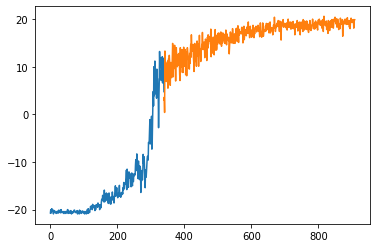

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

d1 = pd.read_csv('/content/drive/My Drive/ML/RL/pong_rewards_list1.csv')
d2 = pd.read_csv('/content/drive/My Drive/ML/RL/pong_rewards_list2.csv')
d3 = pd.read_csv('/content/drive/My Drive/ML/RL/pong_rewards_list3.csv')
d = pd.concat([d1,d2,d3], ignore_index=True)
k = []
f = 10
for i in range(0,len(d),f):
  k.append(np.mean(d[i:i+f]))

plt.plot(k)


In [ ]:
from numpy import savetxt
frame_number = 0
rewards_list = []
loss_list = []
n_actions = env.action_space.n
 
replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE,MINIBATCH_SIZE)
model1 = build_dueling_q_network(n_actions, learning_rate=LEARNING_RATE, input_shape=(80, 80), history_length=HISTORY_LENGTH)
model2 = build_dueling_q_network(n_actions, learning_rate=LEARNING_RATE, input_shape=(80, 80), history_length=HISTORY_LENGTH)
#model1.load_weights(save_dirr)
#model2.load_weights(save_dirr)
# model1 = tf.keras.models.load_model(save_dirr +'dqn_pong.h5')
# model2 = tf.keras.models.load_model(save_dirr +'dqn_pong.h5')
agent = Agent(model1,model2,n_actions,GAMMA,MINIBATCH_SIZE)
 
 
 
for epochs in range(NUM_EPOCHS):
 
  start_time = time.time()
  frame = env.reset()
  state = np.repeat(process_frame(frame), HISTORY_LENGTH, axis=2)
  last_lives = 0
  life_lost = True
  episode_reward_sum = 0
 
  if epochs % WEIGHT_SAVE_FREQ == 0 and len(rewards_list)>1:
      savetxt('/content/drive/My Drive/ML/RL/pong_rewards_list1.csv', np.asarray(rewards_list), delimiter=',')
      agent.model1.save(save_dirr+'dqn_pong.h5')
      print('saved')
 
  for _ in range(MAX_EPISODE_LENGTH):
      action = agent.get_action(calc_epsilon(frame_number), state)
      new_frame, reward, terminal, info = env.step(action)
 
      if info['ale.lives'] < last_lives:
        life_lost = True
      else:
        life_lost = terminal
 
      last_lives = info['ale.lives']
 
      new_processed_frame = process_frame(new_frame)
      new_state = np.append(state[:, :, 1:], new_processed_frame, axis=2)
 
      frame_number += 1
      episode_reward_sum += reward
      
      replay_buffer.append( state, action, reward, life_lost, new_state)
 
      state = new_state
 
      # Update agent
      if frame_number % UPDATE_FREQ == 0 and replay_buffer.sizee() > MIN_REPLAY_BUFFER_SIZE:
        experiences = replay_buffer.sample()
        loss = agent.learn(experiences)
 
        loss_list.append(loss)
 
      # Update target network
      if frame_number % TARGET_UPDATE_FREQ == 0 and frame_number > MIN_REPLAY_BUFFER_SIZE:
          agent.model2.set_weights(agent.model1.get_weights())
 
      # Break the loop when the game is over
      if terminal:
          # terminal = False
          break
 
  rewards_list.append(episode_reward_sum)
 
      # Output the progress every 10 games
  if len(rewards_list) % 10 == 0:
      print(f'Game number: {str(len(rewards_list)).zfill(6)}  Frame number: {str(frame_number).zfill(8)}  Average reward: {np.mean(rewards_list[-10:]):0.1f}  Time taken: {(time.time() - start_time):.1f}s')

Game number: 000010  Frame number: 00009471  Average reward: -20.5  Time taken: 0.8s
Game number: 000020  Frame number: 00019369  Average reward: -20.0  Time taken: 1.1s
Game number: 000030  Frame number: 00028256  Average reward: -20.8  Time taken: 0.8s
Game number: 000040  Frame number: 00037253  Average reward: -20.5  Time taken: 1.1s
Game number: 000050  Frame number: 00046813  Average reward: -19.9  Time taken: 0.9s
Game number: 000060  Frame number: 00055919  Average reward: -20.2  Time taken: 7.8s
Game number: 000070  Frame number: 00065435  Average reward: -20.1  Time taken: 8.8s
Game number: 000080  Frame number: 00074978  Average reward: -20.0  Time taken: 8.0s
Game number: 000090  Frame number: 00084010  Average reward: -20.2  Time taken: 6.8s
Game number: 000100  Frame number: 00092773  Average reward: -20.9  Time taken: 6.8s
saved
Game number: 000110  Frame number: 00101979  Average reward: -20.7  Time taken: 9.1s
Game number: 000120  Frame number: 00111356  Average reward

In [ ]:
from numpy import savetxt
frame_number = 6114961
rewards_list = []
loss_list = []
n_actions = env.action_space.n
 
replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE,MINIBATCH_SIZE)
# model1 = build_dueling_q_network(n_actions, learning_rate=LEARNING_RATE, input_shape=(80, 80), history_length=HISTORY_LENGTH)
# model2 = build_dueling_q_network(n_actions, learning_rate=LEARNING_RATE, input_shape=(80, 80), history_length=HISTORY_LENGTH)
#model1.load_weights(save_dirr)
#model2.load_weights(save_dirr)
model1 = tf.keras.models.load_model(save_dirr +'dqn_pong.h5')
model2 = tf.keras.models.load_model(save_dirr +'dqn_pong.h5')
agent = Agent(model1,model2,n_actions,GAMMA,MINIBATCH_SIZE)
 
 
 
for epochs in range(NUM_EPOCHS):
 
  start_time = time.time()
  frame = env.reset()
  state = np.repeat(process_frame(frame), HISTORY_LENGTH, axis=2)
  last_lives = 0
  life_lost = True
  episode_reward_sum = 0
 
  if epochs % WEIGHT_SAVE_FREQ == 0 and len(rewards_list)>1:
      savetxt('/content/drive/My Drive/ML/RL/pong_rewards_list2.csv', np.asarray(rewards_list), delimiter=',')
      agent.model1.save(save_dirr+'dqn_pong2.h5')
      print('saved')
 
  for _ in range(MAX_EPISODE_LENGTH):
      action = agent.get_action(calc_epsilon(frame_number), state)
      new_frame, reward, terminal, info = env.step(action)
 
      if info['ale.lives'] < last_lives:
        life_lost = True
      else:
        life_lost = terminal
 
      last_lives = info['ale.lives']
 
      new_processed_frame = process_frame(new_frame)
      new_state = np.append(state[:, :, 1:], new_processed_frame, axis=2)
 
      frame_number += 1
      episode_reward_sum += reward
      
      replay_buffer.append( state, action, reward, life_lost, new_state)
 
      state = new_state
 
      # Update agent
      if frame_number % UPDATE_FREQ == 0 and replay_buffer.sizee() > MIN_REPLAY_BUFFER_SIZE:
        experiences = replay_buffer.sample()
        loss = agent.learn(experiences)
 
        loss_list.append(loss)
 
      # Update target network
      if frame_number % TARGET_UPDATE_FREQ == 0 and frame_number > MIN_REPLAY_BUFFER_SIZE:
          agent.model2.set_weights(agent.model1.get_weights())
 
      # Break the loop when the game is over
      if terminal:
          # terminal = False
          break
 
  rewards_list.append(episode_reward_sum)
 
      # Output the progress every 10 games
  if len(rewards_list) % 10 == 0:
      print(f'Game number: {str(len(rewards_list)).zfill(6)}  Frame number: {str(frame_number).zfill(8)}  Average reward: {np.mean(rewards_list[-10:]):0.1f}  Time taken: {(time.time() - start_time):.1f}s')

Game number: 000010  Frame number: 06141454  Average reward: 6.4  Time taken: 13.9s
Game number: 000020  Frame number: 06170518  Average reward: -1.9  Time taken: 34.1s
Game number: 000030  Frame number: 06195774  Average reward: 12.8  Time taken: 23.1s
Game number: 000040  Frame number: 06224732  Average reward: 9.8  Time taken: 27.4s
Game number: 000050  Frame number: 06252733  Average reward: 8.2  Time taken: 33.6s
Game number: 000060  Frame number: 06284141  Average reward: 7.4  Time taken: 42.1s
Game number: 000070  Frame number: 06314801  Average reward: 8.6  Time taken: 35.4s
Game number: 000080  Frame number: 06344705  Average reward: 8.2  Time taken: 24.6s
Game number: 000090  Frame number: 06373788  Average reward: 8.2  Time taken: 41.0s
Game number: 000100  Frame number: 06403261  Average reward: 8.0  Time taken: 31.3s
saved
Game number: 000110  Frame number: 06430747  Average reward: 11.8  Time taken: 33.2s
Game number: 000120  Frame number: 06459996  Average reward: 6.3  T

In [ ]:
from numpy import savetxt
frame_number = 12263817
rewards_list = []
loss_list = []
n_actions = env.action_space.n
 
replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE,MINIBATCH_SIZE)
# model1 = build_dueling_q_network(n_actions, learning_rate=LEARNING_RATE, input_shape=(80, 80), history_length=HISTORY_LENGTH)
# model2 = build_dueling_q_network(n_actions, learning_rate=LEARNING_RATE, input_shape=(80, 80), history_length=HISTORY_LENGTH)
#model1.load_weights(save_dirr)
#model2.load_weights(save_dirr)
model1 = tf.keras.models.load_model(save_dirr +'dqn_pong2.h5')
model2 = tf.keras.models.load_model(save_dirr +'dqn_pong2.h5')
agent = Agent(model1,model2,n_actions,GAMMA,MINIBATCH_SIZE)
 
 
 
for epochs in range(NUM_EPOCHS):
 
  start_time = time.time()
  frame = env.reset()
  state = np.repeat(process_frame(frame), HISTORY_LENGTH, axis=2)
  last_lives = 0
  life_lost = True
  episode_reward_sum = 0
 
  if epochs % WEIGHT_SAVE_FREQ == 0 and len(rewards_list)>1:
      savetxt('/content/drive/My Drive/ML/RL/pong_rewards_list3.csv', np.asarray(rewards_list), delimiter=',')
      agent.model1.save(save_dirr+'dqn_pong3.h5')
      print('saved')
 
  for _ in range(MAX_EPISODE_LENGTH):
      action = agent.get_action(calc_epsilon(frame_number), state)
      new_frame, reward, terminal, info = env.step(action)
 
      if info['ale.lives'] < last_lives:
        life_lost = True
      else:
        life_lost = terminal
 
      last_lives = info['ale.lives']
 
      new_processed_frame = process_frame(new_frame)
      new_state = np.append(state[:, :, 1:], new_processed_frame, axis=2)
 
      frame_number += 1
      episode_reward_sum += reward
      
      replay_buffer.append( state, action, reward, life_lost, new_state)
 
      state = new_state
 
      # Update agent
      if frame_number % UPDATE_FREQ == 0 and replay_buffer.sizee() > MIN_REPLAY_BUFFER_SIZE:
        experiences = replay_buffer.sample()
        loss = agent.learn(experiences)
 
        loss_list.append(loss)
 
      # Update target network
      if frame_number % TARGET_UPDATE_FREQ == 0 and frame_number > MIN_REPLAY_BUFFER_SIZE:
          agent.model2.set_weights(agent.model1.get_weights())
 
      # Break the loop when the game is over
      if terminal:
          # terminal = False
          break
 
  rewards_list.append(episode_reward_sum)
 
      # Output the progress every 10 games
  if len(rewards_list) % 10 == 0:
      print(f'Game number: {str(len(rewards_list)).zfill(6)}  Frame number: {str(frame_number).zfill(8)}  Average reward: {np.mean(rewards_list[-10:]):0.1f}  Time taken: {(time.time() - start_time):.1f}s')

Game number: 000010  Frame number: 12285038  Average reward: 17.2  Time taken: 7.7s
Game number: 000020  Frame number: 12306727  Average reward: 16.5  Time taken: 9.3s
Game number: 000030  Frame number: 12327319  Average reward: 17.6  Time taken: 18.5s
Game number: 000040  Frame number: 12347790  Average reward: 17.6  Time taken: 18.5s
Game number: 000050  Frame number: 12367908  Average reward: 18.0  Time taken: 30.3s
Game number: 000060  Frame number: 12390048  Average reward: 16.9  Time taken: 29.1s
Game number: 000070  Frame number: 12409991  Average reward: 18.2  Time taken: 22.2s
Game number: 000080  Frame number: 12432382  Average reward: 16.8  Time taken: 23.3s
Game number: 000090  Frame number: 12452037  Average reward: 18.6  Time taken: 25.3s
Game number: 000100  Frame number: 12471855  Average reward: 17.9  Time taken: 24.7s
saved
Game number: 000110  Frame number: 12492900  Average reward: 16.7  Time taken: 23.1s
Game number: 000120  Frame number: 12510710  Average reward: 

In [13]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
 
 
 
!pip install gym[atari]
!pip install gym[box2D]
 
!pip install pyvirtualdisplay
!pip install piglet
 
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
 
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
 
 
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
 
from IPython import display as ipythondisplay
 
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
 
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
 
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.7).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [14]:

model = tf.keras.models.load_model(save_dirr +'dqn_pong3.h5')

In [19]:
'''CartPole problem use random action'''
import gym
env = []
env = gym.make('PongDeterministic-v4')
env = wrap_env(env)  # defined before for rendering online

observation = env.reset()
state = np.repeat(process_frame(observation), 4, axis=2)
r = 0
i = 0
last_r = 0
last_lives = 0
life_lost = False
nn = 5
n = 0
last_action = 1
n = np.random.randint(0,10)
n = 0
w = 60
wait = np.random.randint(w)
while True:
  if i%200 == 0:
    print('i',i)
  i = i+1
  env.render()


  # your agent goes here

  # if life_lost or i<n:
  #   action =1
  # else :
  q = model.predict(np.expand_dims(state,axis = 0))   # take a random action
  # probs = softmax(q, tau=0.0000001)
  # action = np.random.choice(env.action_space.n, p=probs.squeeze())
  action = np.argmax(q)
  if wait >0:
    wait = wait-1
    action = 0
    # n = 0
  # if q.max()-q.min()<0.2:
  #   action = last_action

  observation, reward, done, info = env.step(action) 
  last_action = action
  # if info['ale.lives'] < last_lives:
  #   life_lost = True
  # else:
  #   life_lost = done
  # last_lives = info['ale.lives']

  new_processed_frame = process_frame(observation)
  state = np.append(state[:, :, 1:], new_processed_frame, axis=2)
  r = r+reward
  if r!=last_r:
    print(r)
    last_r = r
    wait = np.random.randint(w)

  if done: 
    break;
print(r)            
env.close()
show_video()

i 0
1.0
2.0
i 200
3.0
4.0
5.0
i 400
6.0
7.0
i 600
8.0
9.0
10.0
i 800
11.0
12.0
i 1000
13.0
14.0
15.0
i 1200
16.0
17.0
i 1400
16.0
15.0
14.0
i 1600
13.0
12.0
13.0
i 1800
14.0
15.0
16.0
16.0
